In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from image_helper import ImageHelper
from custom_image_dataset import CustomImageDataset
from srcnn_model import SRCNN

Criando as transformações:
- `transform_x`: Reduz e aumenta a resolução, deixando a imagem borrada com 512 x 512 de resolução
- `transform_y`: transforma resolução em 512 x 512 para podermos comparar com os dados X


In [13]:
transform_x = transforms.Compose([
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),   # resize image to 33x33 and downsample by BICUBIC interpolation 
    transforms.Resize((512, 512), interpolation=Image.BICUBIC)  # resize image to 512x512
])

transform_y = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.BICUBIC),   # resize image to 512x512 and downsample by BICUBIC interpolation 
])

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Para os testes iniciais, vou usar o *Set14* como dados de treino e o *Set5* como dados de teste

In [14]:
train_data_set = CustomImageDataset(img_dir="./datasets/Set14/Set14", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(img_dir="./datasets/Set5/Set5", transform=transform_x, target_transform=transform_y)

Exemplo de como ficam o X, y depois das transformações:

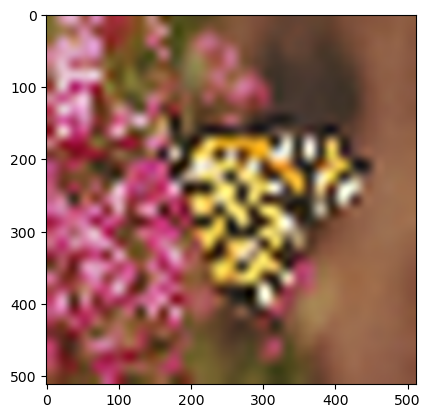

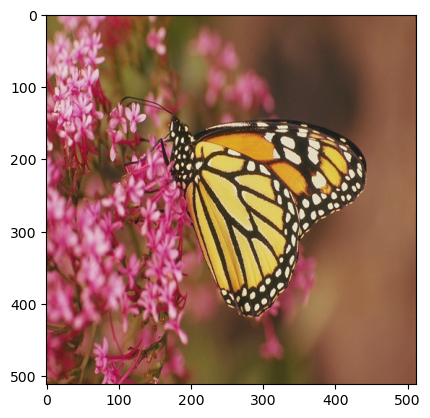

In [15]:
ImageHelperInstance = ImageHelper()
for x, y in train_data_set:
    ImageHelperInstance.show_tensor_as_image(x)
    ImageHelperInstance.show_tensor_as_image(y)
    break

Criando os DataLoader's

In [16]:
# create dataloader to load data in batches
train_loader = DataLoader(train_data_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data_set, batch_size=32, shuffle=True, num_workers=4)

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# hyperparameters
learning_rate_1 = 1e-4 # for first 2 layers
learning_rate_2 = 1e-5 # for last layer
batch_size = 64
epochs = 5

Loss Function, definida como *MSE*

In [19]:
# Initialize the loss function
# The MSE loss function is evaluated only by the difference between the central pixels of Xi and the network output.
loss_fn = nn.MSELoss()

Train e Test loops

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
# Initialize network
model = SRCNN().to(device=device)

In [23]:
# testing if the output shape is the same as the input shape
a = torch.randn(3, 33, 33)
model(a).shape

torch.Size([3, 25, 25])

Criando um otimizador

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_1)

Testando o modelo

In [26]:
train_loop(train_loader, model, loss_fn, optimizer)

RuntimeError: expected scalar type Byte but found Float